# Distilling the Knowledge in a Neural Network
### Reference
1. [paper](https://arxiv.org/abs/1503.02531)
2. [keras](https://keras.io/examples/vision/knowledge_distillation/)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend

# Teacher model

In [2]:
def building_block(X, filter, args, stage, block):
  x = layers.BatchNormalization()(X)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filter,
                    kernel_size=(3, 3),
                    strides=(1, 1) if stage == 0 or block > 0 else (2, 2),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(x)

  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filter,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(x)

  if stage == 0 or block > 0:
    out = layers.Add()([x, X])
  else:
    id = layers.Conv2D(filters=filter,
                       kernel_size=(1, 1),
                       strides=(2, 2),
                       padding='same',
                       kernel_initializer=args.init,
                       kernel_regularizer=args.reg)(X)
    out = layers.Add()([x, id])
  return out

In [3]:
def get_model(X, args):
  x = layers.Conv2D(filters=args.filters[0],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.init,
                    kernel_regularizer=args.reg)(X)
  for stage, filter in enumerate(args.filters):
    for block in range(args.blocks):
      x = building_block(x, filter, args, stage, block)
      print(f'{stage+2}-{block+1}block {x.shape}')

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=args.num_class)(x)
  return x

In [4]:
def build_model(args):
  X = layers.Input(shape=args.input_shape)
  x = get_model(X, args)
  model = models.Model(inputs=X, outputs=x)
  return model

In [5]:
class Config:
  lr = 1e-2
  batch_size = 128
  epochs = 5
  weight_decay = 1e-4
  decay_step = 2
  input_shape = (28, 28, 1)
  filters = [16, 32, 64]
  blocks = 3
  num_class = 10
  opt = optimizers.Adam(learning_rate=lr)
  loss = losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = metrics.SparseCategoricalAccuracy()
  init = initializers.HeNormal()
  reg = regularizers.L2(l2=weight_decay)

In [6]:
big_model = build_model(Config)

2-1block (None, 28, 28, 16)
2-2block (None, 28, 28, 16)
2-3block (None, 28, 28, 16)
3-1block (None, 14, 14, 32)
3-2block (None, 14, 14, 32)
3-3block (None, 14, 14, 32)
4-1block (None, 7, 7, 64)
4-2block (None, 7, 7, 64)
4-3block (None, 7, 7, 64)


In [7]:
def input_pipeline(feature, label, batch_size, validation_split:float=0.1, pad:int=4):
  try:
    N, H, W, C = feature.shape
  except:
    feature = tf.expand_dims(feature, axis=-1)
    N, H, W, C = feature.shape

  ds = tf.data.Dataset.from_tensor_slices((feature, label))
  ds = ds.map(lambda x, y: (tf.divide(tf.cast(x, tf.float32), 255.), y))
  ds = ds.map(lambda x, y: (tf.divide(tf.subtract(x, tf.math.reduce_mean(x)), tf.math.reduce_std(x)), y))
  ds = ds.shuffle(1000)
  ds = ds.cache()

  assert 0 <= validation_split < 1
  if validation_split:
    val_len = int(N * validation_split)
    val_ds = ds.take(val_len)
    train_ds = ds.skip(val_len)

  crop = train_ds.map(lambda x, y: (tf.image.resize_with_pad(x, H+pad*2, W+pad*2), y))
  crop = crop.map(lambda x, y: (tf.image.random_crop(x, (H, W, C)), y))
  train_ds = train_ds.concatenate(crop)
  train_ds = train_ds.shuffle(1000)
  train_ds = train_ds.cache()
  train_ds = train_ds.batch(batch_size=batch_size)
  val_ds = val_ds.batch(batch_size=batch_size)
  val_ds = val_ds.prefetch(1)
  train_ds = train_ds.prefetch(1)
  print('Trian mini batch: ', train_ds.cardinality().numpy(), '           val mini batch: ', val_ds.cardinality().numpy())
  return train_ds, val_ds

In [60]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [9]:
train_ds, val_ds = input_pipeline(x_train, y_train, Config.batch_size)

Trian mini batch:  844            val mini batch:  47


In [13]:
class DecoupleHelper(callbacks.Callback):
  def __init__(self, init_lr, decay_steps, regularizer:bool=None):
    self.init_lr = init_lr
    self.regularizer = regularizer
    self.weight_decay = None
    if self.regularizer:
      self.weight_decay = self.regularizer.l2
    self.decay_steps = decay_steps
    self.best_acc = None
    self.best_weights = None
    self.best_epoch = None
    self.iter_counter = 0

  def on_train_begin(self, logs=None):
    if not hasattr(self.model.optimizer.lr, 'lr'):
      backend.set_value(self.model.optimizer.lr, self.init_lr)

  def on_epoch_end(self, epoch, logs=None):
    next_lr = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=self.init_lr,
                                                       first_decay_steps=self.decay_steps)(epoch).numpy()
    backend.set_value(self.model.optimizer.lr, next_lr)
    logs.update({'next_lr': next_lr})
    if self.regularizer:
      next_wd = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=self.weight_decay,
                                                         first_decay_steps=self.decay_steps)(epoch).numpy()
      self.regularizer.lr = next_wd
      logs.update({'next_wd': next_wd})
    curr_acc = logs.get('val_sparse_categorical_accuracy')
    if self.best_acc is None:
      self.best_acc = curr_acc
    
    if self.best_acc < curr_acc:
      self.best_acc = curr_acc
      self.best_weights = self.model.get_weights()
      self.best_epoch = epoch
      logs.update({'WEIGHT UPDATED': True})

  def on_train_end(self, logs=None):
    if self.best_weights:
      self.model.set_weights(self.best_weights)
      print('Training end')

## Train teacher model

In [11]:
big_model.compile(optimizer=Config.opt,
              loss=Config.loss,
              metrics=Config.metric)

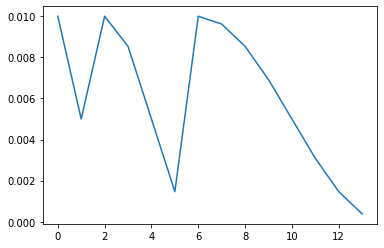

In [21]:
import numpy as np
import matplotlib.pyplot as plt
log = []
for i in range(14):
  lr = optimizers.schedules.CosineDecayRestarts(initial_learning_rate=1e-2, first_decay_steps=2)(i).numpy()
  log.append(lr)

plt.plot(log)

In [23]:
big_model.fit(x=train_ds,
          validation_data=val_ds,
          epochs=6,
          callbacks=[DecoupleHelper(init_lr=Config.lr,
                                    decay_steps=Config.decay_step,
                                    regularizer=Config.reg)])

Epoch 1/6
844/844 [==============================] - 1023s 1s/step - loss: 0.1546 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.8071 - val_sparse_categorical_accuracy: 0.7617 - next_lr: 0.0100 - next_wd: 1.0000e-04
Epoch 2/6
844/844 [==============================] - 1005s 1s/step - loss: 0.1396 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.2481 - val_sparse_categorical_accuracy: 0.9485 - next_lr: 0.0050 - next_wd: 5.0000e-05 - WEIGHT UPDATED: 1.0000
Epoch 3/6
844/844 [==============================] - 1140s 1s/step - loss: 0.0934 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.1899 - val_sparse_categorical_accuracy: 0.9657 - next_lr: 0.0100 - next_wd: 1.0000e-04 - WEIGHT UPDATED: 1.0000
Epoch 4/6
844/844 [==============================] - 1019s 1s/step - loss: 0.1397 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.9318 - next_lr: 0.0085 - next_wd: 8.5355e-05
Epoch 5/6
844/844 [==============================] - 1012s 1s/step

Text(0.5, 1.0, 'Teacher Model')

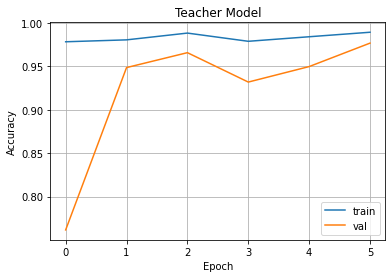

In [107]:
plt.plot(big_model.history.history.get('sparse_categorical_accuracy'), label='train')
plt.plot(big_model.history.history.get('val_sparse_categorical_accuracy'), label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Teacher Model')

# Student model

In [31]:
small_model = models.Sequential()
small_model.add(layers.Input(shape=Config.input_shape))
small_model.add(layers.Conv2D(filters=16,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same'))
small_model.add(layers.Activation(tf.nn.relu))
small_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
small_model.add(layers.Conv2D(filters=32,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same'))
small_model.add(layers.Activation(tf.nn.relu))
small_model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
small_model.add(layers.Conv2D(filters=64,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              padding='same'))
small_model.add(layers.GlobalAveragePooling2D())
small_model.add(layers.Dense(units=Config.num_class))

# Distiller class

In [95]:
class Distiller(models.Model):
  def __init__(self, teacher, student):
    super(Distiller, self).__init__()
    self.teacher = teacher
    self.student = student
    self.t = None
    self.alpha = None
    self.student_objective = None
    self.distiller_objective = None

  def compile(self, optimizer, metrics, distiller_objective, student_objective, t, alpha):
    super(Distiller, self).compile(optimizer=optimizer, metrics=metrics,)
    self.distiller_objective = distiller_objective
    self.student_objective = student_objective
    self.t = t
    self.alpha = alpha

  def train_step(self, data):
    x, y = data
    teacher_pred = self.teacher(x, training=False)   # (batch, num_class)
    with tf.GradientTape() as tape:
      student_pred = self.student(x, training=True)   # (batch, num_class)
      distiller_loss = self.distiller_objective(tf.nn.softmax(teacher_pred / self.t, axis=1),
                                                tf.nn.softmax(student_pred / self.t, axis=1))
      student_loss = self.student_objective(y, teacher_pred)
      loss = (1 - self.alpha) * distiller_loss + self.alpha * student_loss

    trainable = self.student.trainable_weights
    grads = tape.gradient(loss, trainable)
    self.optimizer.apply_gradients(zip(grads, trainable))
    self.compiled_metrics.update_state(y, student_pred)

    results = {m.name: m.result() for m in self.metrics}
    print(results)
    results.update({'student_loss': student_loss,
                    'distiller_loss': distiller_loss})
    return results

  def test_step(self, data):
    x, y = data
    val_pred = self.student(x, training=False)
    val_loss = self.student_objective(y, val_pred)

    self.compiled_metrics.update_state(y, val_pred)
    results = {m.name: m.result() for m in self.metrics}
    results.update({'val_student_loss': val_loss})
    return results

In [61]:
x_train = x_train/255.
x_train = (x_train - tf.math.reduce_mean(x_train)) / tf.math.reduce_std(x_train)

In [62]:
y_train = tf.expand_dims(y_train, axis=1)
x_train = tf.expand_dims(x_train, axis=3)

In [98]:
distiller = Distiller(teacher=big_model, student=small_model)
distiller.compile(
    optimizer=optimizers.Adam(learning_rate=Config.lr),
    metrics=metrics.SparseCategoricalAccuracy(),
    distiller_objective=losses.KLDivergence(),
    student_objective=losses.SparseCategoricalCrossentropy(from_logits=True),
    alpha=0.1,
    t=10
    )

In [ ]:
distiller.fit(
    x=x_train,
    y=y_train,
    epochs=5,
    validation_split=0.2
    )

```
Epoch 1/5
1500/1500 [==============================] - 179s 118ms/step - sparse_categorical_accuracy: 0.7550 - student_loss: 0.1346 - distiller_loss: 0.0332 - val_sparse_categorical_accuracy: 0.8675 - val_val_student_loss: 0.4981
Epoch 2/5
1500/1500 [==============================] - 184s 122ms/step - sparse_categorical_accuracy: 0.8842 - student_loss: 0.1346 - distiller_loss: 0.0201 - val_sparse_categorical_accuracy: 0.8907 - val_val_student_loss: 0.3469
Epoch 3/5
1500/1500 [==============================] - 167s 111ms/step - sparse_categorical_accuracy: 0.8972 - student_loss: 0.1347 - distiller_loss: 0.0183 - val_sparse_categorical_accuracy: 0.9014 - val_val_student_loss: 0.3046
Epoch 4/5
1500/1500 [==============================] - 172s 115ms/step - sparse_categorical_accuracy: 0.9050 - student_loss: 0.1347 - distiller_loss: 0.0171 - val_sparse_categorical_accuracy: 0.9130 - val_val_student_loss: 0.2528
Epoch 5/5
1500/1500 [==============================] - 199s 133ms/step - sparse_categorical_accuracy: 0.9056 - student_loss: 0.1346 - distiller_loss: 0.0166 - val_sparse_categorical_accuracy: 0.9047 - val_val_student_loss: 0.2331
<keras.callbacks.History at 0x7fdc591cf190>
```

Text(0.5, 1.0, 'Distilled model')

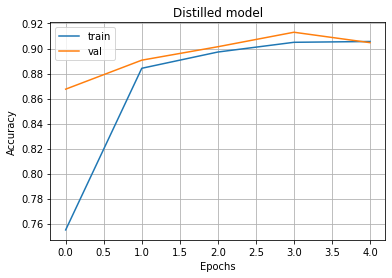

In [106]:
plt.plot(distiller.history.history.get('sparse_categorical_accuracy'), label='train')
plt.plot(distiller.history.history.get('val_sparse_categorical_accuracy'), label='val')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Distilled model')

In [126]:
x_test = x_test/255.
x_test = (x_test - tf.math.reduce_mean(x_test)) / tf.math.reduce_std(x_test)

In [ ]:
distiller.evaluate(x_test, y_test)

```
313/313 [==============================] - 6s 18ms/step - sparse_categorical_accuracy: 0.8977 - val_student_loss: 0.3136
[0.8977000117301941, 0.12452390789985657]
```

In [ ]:
big_model.evaluate(x_test, y_test)

```
313/313 [==============================] - 46s 142ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9616
[0.1774003952741623, 0.9616000056266785]
```